In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -n -q /content/drive/MyDrive/Colab\ Notebooks/sptm/traj.zp

In [ ]:
!pip install -qqq  pytorch-lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.7 MB/s eta 0:00:00


In [ ]:
from torch import nn ,rand,flatten,stack,device
import torch
from torchvision import models ,io ,transforms
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np
import h5py
import copy
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint,LearningRateFinder
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.nn import functional as F
from numpy import asarray
from torchmetrics.regression import MeanSquaredError
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# batch_normalization_18 (BatchNor (None, 1024)          4096
# ____________________________________________________________________________________________________
# activation_18 (Activation)       (None, 1024)          0
# ____________________________________________________________________________________________________
# dense_2 (Dense)                  (None, 512)           524800
# ____________________________________________________________________________________________________
# batch_normalization_19 (BatchNor (None, 512)           2048
# ____________________________________________________________________________________________________
# activation_19 (Activation)       (None, 512)           0
# ____________________________________________________________________________________________________
# dense_3 (Dense)                  (None, 512)           262656
# ____________________________________________________________________________________________________
# batch_normalization_20 (BatchNor (None, 512)           2048
# ____________________________________________________________________________________________________
# activation_20 (Activation)       (None, 512)           0
# ____________________________________________________________________________________________________
# dense_4 (Dense)                  (None, 512)           262656
# ____________________________________________________________________________________________________
# batch_normalization_21 (BatchNor (None, 512)           2048
# ____________________________________________________________________________________________________
# activation_21 (Activation)       (None, 512)           0
# ____________________________________________________________________________________________________
# dense_5 (Dense)                  (None, 512)           262656
# ____________________________________________________________________________________________________
# batch_normalization_22 (BatchNor (None, 512)           2048
# ____________________________________________________________________________________________________
# activation_22 (Activation)       (None, 512)           0
# ____________________________________________________________________________________________________
# dense_6 (Dense)                  (None, 2)             1026
# ====================================================================================================

resnet_weights=models.ResNet18_Weights.IMAGENET1K_V1
class SPTM(nn.Module):
    def __init__(self) -> None:
        super(SPTM, self).__init__()
        self.encoder=models.resnet18(weights=resnet_weights)
        modules = list(self.encoder.children())[:-1] # delete the last fc layer.
        self.encoder = nn.Sequential(*modules)
        ### Now set requires_grad to false
        for param in self.encoder.parameters():
           param.requires_grad = False

        self.linear_layers = nn.Sequential(
            nn.Linear(512 + 512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )
        self.softmax=nn.Softmax(dim=1)


    def flatten(self, z):
        # z = nn.functional.adaptive_avg_pool2d(z, (1, 1))
        # z = flatten(z, 1)
        z=torch.flatten(z,start_dim=1)
        return z

    def forward(self,inp):
        # print("shape",inp.shape)
        obs_img = inp[:,0]
        goal_img = inp[:,1]
        # print(goal_img.shape)
        obs_img=obs_img.to(device)
        goal_img=goal_img.to(device)
        # obs_img=stack(obs_img).to(device)
        # goal_img=stack(goal_img).to(device)
        obs_encoding = self.encoder(obs_img)
        obs_encoding = self.flatten(obs_encoding)
        goal_encoding = self.encoder(goal_img)
        goal_encoding = self.flatten(goal_encoding)
        z = torch.cat([obs_encoding, goal_encoding], dim=1)
        # print("z",z.shape)
        # z = self.flatten(z)
        z = self.linear_layers(z)
        z=self.softmax(z)
        # torch.round(z)
        return z

##Generate data

In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
transform=resnet_weights.transforms()
def load_image_resnet(path):
    # load the image and convert into
    # numpy array
    img = Image.open(path)
    # asarray() class is used to convert
    # PIL images into NumPy arrays
    # numpydata = asarray(img)
    return transform(img)


In [ ]:
episodes=[]
for root, dirs, files in os.walk("/content/traj/images", topdown=False):
  for name in files:
    episodes.append(os.path.join(root, name))
# for root, dirs, files in os.walk("/content/mega/backup", topdown=False):
#   for name in files:
#     episodes.append(os.path.join(root, name))


In [ ]:
def generator_sptm_2():
  episode=0
  while True:
      start_index=random.randint(0,len(episodes)-1)
      end_index=min(random.randint(start_index,start_index+20),len(episodes)-1)
      dif=end_index-start_index
      if dif > 0 and dif<10:
        y=0
      else:
        y=1
      future_x = load_image_resnet(episodes[end_index])
      current_x = load_image_resnet(episodes[start_index])
      prev_y=y
      yield (stack([current_x,future_x]),float(y)
                        )


In [ ]:
# train_ds=list(set([j for i,j in zip(range(24000),generator_sptm_2())]))
# def get_label(v):
#   return v[1]
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.hist(list(map(get_label,train_ds)))
# plt.show()

KeyboardInterrupt: ignored

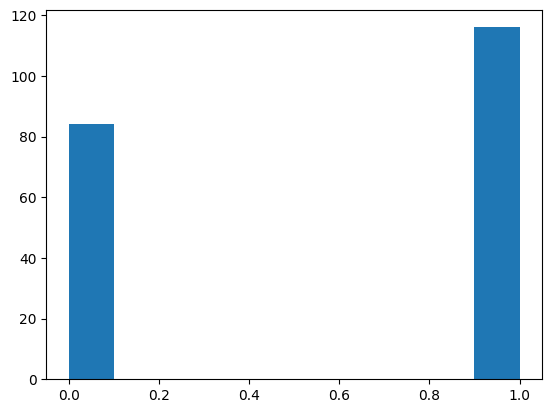

In [ ]:
val_ds=list(set([j for i,j in zip(range(200),generator_sptm_2())]))
def get_label(v):
  return v[1]
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(get_label,val_ds)))
plt.show()

In [ ]:
#source https://stackoverflow.com/questions/73228139/how-to-convert-a-generator-to-a-pytorch-dataloader
class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, generator):
        self.generator = generator

    def __iter__(self):
        return self.generator()
#source https://stackoverflow.com/questions/73228139/how-to-convert-a-generator-to-a-pytorch-dataloader
class IterDatasetV2(torch.utils.data.IterableDataset):
    def __init__(self, iterator):
        self.iterator = iterator
    def __iter__(self):
        return self.iterator



In [ ]:
class Validation(torch.utils.data.Dataset):
    def __init__(self, arr):
        self.arr=arr
    def __len__(self):
        return len(self.arr)
    def __getitem__(self, idx):
        return self.arr[idx]

In [ ]:
from torchmetrics.classification import BinaryAccuracy
class SPTMModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder=models.resnet18(weights=resnet_weights)
        modules = list(self.encoder.children())[:-1] # delete the last fc layer.
        self.encoder = nn.Sequential(*modules)
        ### Now set requires_grad to false
        for param in self.encoder.parameters():
          param.requires_grad = False
        self.linear_layers = nn.Sequential(
            nn.Linear(512 + 512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )
        # self.softmax=nn.Softmax(dim=1)
        self.accuracy = BinaryAccuracy()

    def flatten(self, z):
        # z = nn.functional.adaptive_avg_pool2d(z, (1, 1))
        # z = flatten(z, 1)
        z=torch.flatten(z,start_dim=1)
        return z

    def forward(self,inp):
        # print("shape",inp.shape)
        obs_img = inp[:,0]
        goal_img = inp[:,1]
        # print(goal_img.shape)
        obs_img=obs_img.to(device)
        goal_img=goal_img.to(device)
        # obs_img=stack(obs_img).to(device)
        # goal_img=stack(goal_img).to(device)
        obs_encoding = self.encoder(obs_img)
        obs_encoding = self.flatten(obs_encoding)
        goal_encoding = self.encoder(goal_img)
        goal_encoding = self.flatten(goal_encoding)
        z = torch.cat([obs_encoding, goal_encoding], dim=1)
        # print("z",z.shape)
        # z = self.flatten(z)
        z = self.linear_layers(z)
        # z = self.softmax(z)
        # torch.round(z)
        z=F.log_softmax(z, dim=1)
        return z

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y=y.clone().detach()
        y=y.type(torch.LongTensor).to(device)
        loss =F.nll_loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y=y.clone().detach()
        y=y.type(torch.LongTensor).to(device)
        loss =F.nll_loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(self.parameters(), lr=1e-2)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min"),
                "monitor": "val_loss",
                "frequency": 1
            },
        }
    def train_dataloader(self):
        dataset=IterDataset(generator_sptm_2)
        return torch.utils.data.DataLoader(dataset, batch_size=60,num_workers=2)

    def val_dataloader(self):
        dataset=Validation(val_ds)
        return torch.utils.data.DataLoader(dataset, batch_size=32,num_workers=2)

In [ ]:
experiment_dir="/content/drive/MyDrive/Colab Notebooks/sptm/original"
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(
    save_dir=experiment_dir,
    name='log'
)
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",filename="best"
    , dirpath=experiment_dir, save_top_k=1, save_last=False, mode="max"
)

# early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)

In [ ]:
sptm_trainer = pl.Trainer(
    # callbacks=[checkpoint_callback,
    #            early_stopping_callback
    #            ],
    callbacks=[checkpoint_callback],
    default_root_dir=experiment_dir,
    min_epochs=10,
    max_epochs=250,
    fast_dev_run=False,
    logger=[csv_logger],
    val_check_interval=60,
    # limit_val_batches=32,
    limit_train_batches=400
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# # # import warnings
# # # warnings.filterwarnings(action='once')
#it takes long to generate the dataset
sptm_model = SPTMModule()
sptm_trainer.fit(model=sptm_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.2MB/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/sptm/original exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type           | Params
-------------------------------------------------
0 | encoder       | Sequential     | 11.2 M
1 | linear_layers | Sequential     | 2.4 M 
2 | accuracy      | BinaryAccuracy | 0     
-------------------------------------------------
2.4 M     Trainable params
11.2 M    Non-trainable params
13.5 M    Total params
54.184    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

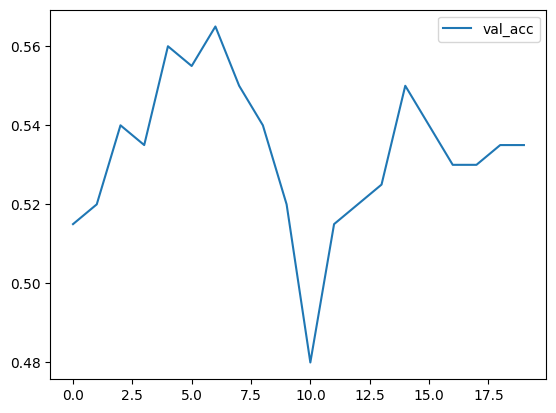

In [ ]:
#plot training stuff
def remove_nan(l):
  refined=[]
  for x in l:
    if not np.isnan(x):
      refined.append(x)
  return refined
import matplotlib.pyplot as plt
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sptm/original/log/version_9/metrics.csv")
plt.figure()
train_loss=remove_nan(df["train_loss_epoch"])
val_loss=remove_nan(df["val_acc"])
# plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_acc")
# plt.plot(df["val_loss"],label="val_loss")
plt.legend()
plt.show()


In [ ]:
!unzip -n -q /content/drive/MyDrive/Colab\ Notebooks/sptm/mega.zip

In [ ]:
df=pd.read_csv("/content/mega/out-old.csv")
timestamps=df["timestamps"][:1000]
# timestamps=list(map(lambda x: (x-timestamps[0])/(timestamps[0]-timestamps[len(timestamps)-1]),timestamps))
timestamps=(max(timestamps)-timestamps)/(max(timestamps)-min(timestamps))
files=list(map(lambda x: "/content/mega/backup/"+x.split("/")[-1],df["filepath"]))[:1000]
dt=list(zip(files,timestamps))

In [ ]:
weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1

In [ ]:
transform=weights.transforms()
def load_image_vanilla(path):
    # load the image and convert into
    # numpy array
    # print("path",path)
    img = Image.open(path)

    # asarray() class is used to convert
    # PIL images into NumPy arrays
    # numpydata = asarray(img)
    return transform(img)


In [ ]:
def generator_custom():
   prev=0
   while True:
    # for i in range(len(dt)):
       x1,x2=random.choices(dt,k=2)
      #  print("x1 x2",x1,x2)
      #  x2=dt[random.randint(dt.index(x1),dt.index(x1)+8)]
       time_distance=x1[1]-x2[1]
       if time_distance<0:
         if prev==0:
            continue
         else:
            y=0
       else:
          y=time_distance
       prev=y
       future_x = load_image_vanilla(x2[0])
       current_x = load_image_vanilla(x1[0])

       yield stack([current_x,future_x]),y


[0.20820590596038546, 0.3221375270883548, 0.6229329994883561, 0.4015225841554404, 0.11431748440963063, 0.03093233829625419, 0.07443272602620421, 0.059017966645518505, 0.19806666667398698, 0.08689254688322778, 0.14798469725266075, 0.26629396140828676, 0.014765882038766831, 0.0478246636140543, 0.11021597224921902, 0.13947430520631443, 0.03589818478047735, 0.4633878622830461, 0.033874761548026155, 0.17528148393285192, 0.026888597375644627, 0.43505613685461986, 0.35958076192793853, 0.6545941118775173, 0.45333482393093955, 0.2091398226178982, 0.15615167720851353, 0.5725998294877155, 0.017875405534314825, 0.19657287599854772, 0.17148333403806826, 0.039954541228826496, 0.2970482858954242, 0.3968810247648801, 0.36990802867319206, 0.634800508786024, 0.473626920589972, 0.22769243970686015, 0.27706876071791725, 0.0863653133054737, 0.25942313204267803, 0.37856589468723584, 0.36220921011629076, 0.04788593903450378, 0.3247092089824448, 0.6929553441779259, 0.211338156502217, 0.28640624203995413, 0.11

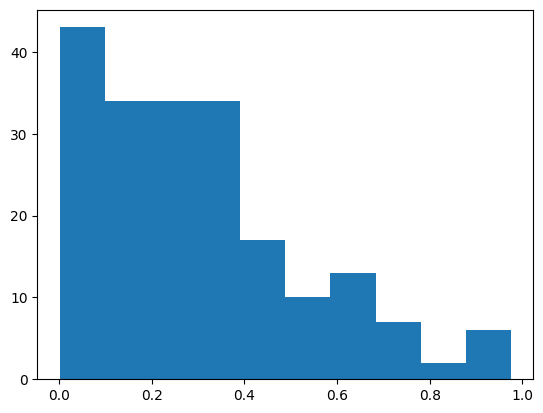

In [ ]:
train_ds=[j for i,j in zip(range(4000),generator_custom())]
def get_label(v):
  return v[1]
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(get_label,train_ds)))
plt.show()

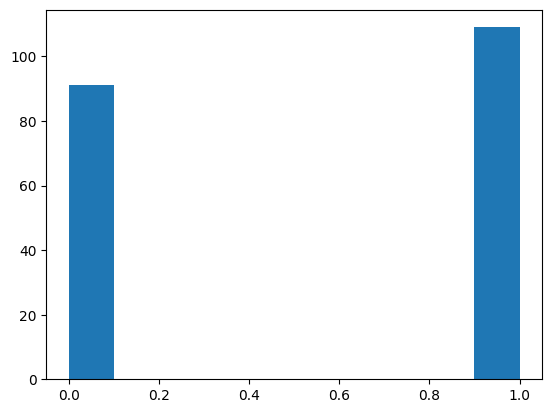

In [ ]:
val_ds=[j for i,j in zip(range(200),generator_sptm_2())]
def get_label(v):
  return v[1]
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(get_label,val_ds)))
plt.show()

In [ ]:
class VanillaSimilarity(nn.Module):
    def __init__(self) -> None:
        super(VanillaSimilarity, self).__init__()
        self.encoder=models.efficientnet_v2_m(weights=weights).features
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.linear_layers = nn.Sequential(
            nn.Linear(self.encoder[-1].out_channels , 1024),
            nn.ReLU(),
            nn.Linear(1024,512 ),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8)
        )
        self.predictor = nn.Sequential(
            nn.Linear(8, 1),
        )

    def flatten(self, z):
        z = nn.functional.adaptive_avg_pool2d(z, (1, 1))
        z = flatten(z, 1)
        return z
    def forward(self,inp):
        obs_img = inp[:,0]
        goal_img = inp[:,1]
        # print(goal_img.shape)
        obs_img=obs_img.to(device)
        goal_img=goal_img.to(device)
        obs_encoding = self.encoder(obs_img)
        obs_encoding = self.flatten(obs_encoding)

        goal_encoding = self.encoder(goal_img)
        goal_encoding = self.flatten(goal_encoding)

        z = torch.cat([obs_encoding, goal_encoding], dim=1)
        z = self.linear_layers(z)
        similarity = self.predictor(z)
        return similarity

In [ ]:
class VanillaSimilarityModule(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        self.model=model
        # self.mse = MeanSquaredError()
        # self.mse=self.mse.to(device)


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        # print(y_hat,y)
        y_hat=y_hat.squeeze(1)
        # print("loss",y_hat.shape)
        loss = nn.functional.mse_loss(y_hat, torch.tensor(y).float().to(y_hat.device))
        self.log("train_loss", loss,on_step=True, on_epoch=True, prog_bar=True, logger=True,batch_size=32)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y_hat=y_hat.squeeze(1)
        # print("loss",y_hat.shape)
        loss = nn.functional.mse_loss(y_hat, torch.tensor(y).float().to(y_hat.device))
        self.log("val_loss", loss,on_step=False, on_epoch=True, prog_bar=True, logger=True,batch_size=32)
        return loss

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(self.parameters(), lr=1e-2)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min"),
                "monitor": "val_loss",
                "frequency": 1
            },
        }
    def val_dataloader(self):
        dataset=IterDataset(generator_custom)
        return torch.utils.data.DataLoader(dataset, batch_size=32,num_workers=2)

    def train_dataloader(self):
        dataset=IterDataset(generator_custom)
        return torch.utils.data.DataLoader(dataset, batch_size=32,num_workers=2)


In [ ]:
experiment_dir="/content/drive/MyDrive/Colab Notebooks/sptm/vanilla"
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(
    save_dir=experiment_dir,
    name='log'
)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",filename="best"
    , dirpath=experiment_dir, save_top_k=1, save_last=False, mode="min"
)

early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)

In [ ]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    default_root_dir=experiment_dir,
    min_epochs=10,
    max_epochs=150,
    fast_dev_run=False,
    logger=[csv_logger],
    val_check_interval=100,
    limit_val_batches=10,
    limit_train_batches=100
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# model=VanillaSimilarity()
# simlarityModel = VanillaSimilarityModule(model)
# trainer.fit(model=simlarityModel)

In [ ]:
class NNCosineSimilarity(nn.Module):
    def __init__(self) -> None:
        super(NNCosineSimilarity, self).__init__()
        self.encoder=models.efficientnet_v2_m(weights=weights).features
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.linear_layers = nn.Sequential(
            nn.Linear(self.encoder[-1].out_channels , 1024),
            nn.ReLU(),
            nn.Linear(1024,512 ),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8)
        )
        self.predictor = nn.CosineSimilarity()

    def flatten(self, z):
        z = nn.functional.adaptive_avg_pool2d(z, (1, 1))
        z = flatten(z, 1)
        return z
    def forward(self,inp):
        obs_img = inp[:,0]
        goal_img = inp[:,1]
        # print(goal_img.shape)
        obs_img=obs_img.to(device)
        goal_img=goal_img.to(device)
        obs_encoding = self.encoder(obs_img)
        obs_encoding = self.flatten(obs_encoding)

        goal_encoding = self.encoder(goal_img)
        goal_encoding = self.flatten(goal_encoding)
        goal = self.linear_layers(goal_encoding)
        obs  = self.linear_layers(obs_encoding)
        similarity = self.predictor(goal,obs)
        return similarity

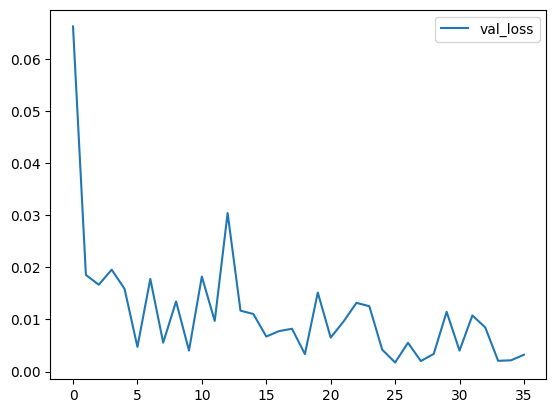

In [ ]:
#plot training stuff
def remove_nan(l):
  refined=[]
  for x in l:
    if not np.isnan(x):
      refined.append(x)
  return refined
import matplotlib.pyplot as plt
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sptm/vanilla/log/version_15/metrics.csv")
plt.figure()
# train_loss=remove_nan(df["train_loss_epoch"])
val_loss=remove_nan(df["val_loss"])
# plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
# plt.plot(df["val_loss"],label="val_loss")
plt.legend()
plt.show()


In [ ]:
#benchmark vanilla and sptm
def convert_continous_to_discrete_categorical(x):

  y=nn.functional.sigmoid(x)>0.6
  y=y.squeeze()
  print(y.shape)

  y=nn.functional.one_hot(y,num_classes=2)
  return y





In [ ]:
!unzip -n -q /content/drive/MyDrive/Colab\ Notebooks/sptm/validation.zip -d validation

In [ ]:
episodes=[]
for root, dirs, files in os.walk("/content/validation", topdown=False):
  for name in files:
    episodes.append(os.path.join(root, name))
def generator_sptm_validation():
  prev_y=0
  while True:
      start_index=random.randint(0,len(episodes)-1)
      end_index=min(random.randint(start_index,start_index+8),len(episodes)-1)
      dif=end_index-start_index
      if dif > 0 and dif<5:
        y=0
      else:
        y=1
      future_x = episodes[end_index]
      current_x = episodes[start_index]
      prev_y=y
      yield ([current_x,future_x],to_categorical(y,2)
                        )


In [ ]:
#load checkpoints
#sptm
model=SPTM()
model=model.to(device)
sptm_model = SPTMModule.load_from_checkpoint("/content/drive/MyDrive/Colab Notebooks/sptm/original/best-v1.ckpt",model=model)
sptm_model.eval()
#vanilla
model=VanillaSimilarity()
model=model.to(device)
vanilla_model = VanillaSimilarityModule.load_from_checkpoint("/content/drive/MyDrive/Colab Notebooks/sptm/vanilla/best-v6.ckpt",model=model)
vanilla_model.eval()

VanillaSimilarityModule(
  (model): VanillaSimilarity(
    (encoder): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1)

In [ ]:
import os
import matplotlib.pyplot as plt
import PIL
rows = 2
batch=20

In [ ]:

def plot_batch(sptm,gt,vanilla,images,j):
    test=images
    tokens=["similar","not similar"]
    # plt.subplot(int(batch/2),1+j,1)
    # # plt.subplot(int(len(validation_data)/2),2,1)
    # plt.imshow(test[0,:].permute(1,2,0).numpy())
    # # plt.subplot(int(len(validation_data)/2),2,2)
    # plt.subplot(int(batch/2),1+j,2)
    # plt.imshow(test[1,:].permute(1,2,0).numpy())
    print("GT",tokens[np.argmax(gt,axis=0)],"-----SPTM",tokens[np.argmax(sptm,axis=1)],"---Vanilla",tokens[np.argmax(vanilla,axis=1)])

In [ ]:
from torchmetrics.classification  import F1Score,Accuracy,BinaryF1Score
f1_score = Accuracy(task="multiclass",num_classes=2).to(device)
bscore=BinaryF1Score().to(device)
vn=[]
sptm=[]
nnscs=[]

for i,j in zip(generator_sptm_validation(),range(batch)):
    x,y=i
    gt=y
    y=torch.tensor(y).float().to(device).unsqueeze(0)
    sptm_x=stack([load_image_resnet(x[0]),load_image_resnet(x[1])]).unsqueeze(0)
    vanilla_x=stack([load_image_vanilla(x[0]),load_image_vanilla(x[1])]).unsqueeze(0)
    sptm_y=sptm_model(sptm_x)
    # sptm_y=torch.round(sptm_y)
    vanilla_y_r=vanilla_model(vanilla_x)
    print("v",sptm_y,vanilla_y_r)
    vanilla_y=(vanilla_y_r>0.4).long()

    vanilla_y=nn.functional.one_hot(vanilla_y,num_classes=2).float().squeeze(1)
    # print("vanilla",vanilla_y,vanilla_y_r,y)
    sptm.append(sptm_y)
    vn.append(vanilla_y)
    # np.argmax(gt,axis=0)
    plot_batch(sptm_y.cpu().detach(),gt,vanilla_y.cpu().detach(),x,j)


v tensor([[0.3787, 0.6213]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[0.0290]], device='cuda:0', grad_fn=<AddmmBackward0>)
GT similar -----SPTM not similar ---Vanilla similar
v tensor([[0.3787, 0.6213]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[0.0097]], device='cuda:0', grad_fn=<AddmmBackward0>)
GT not similar -----SPTM not similar ---Vanilla similar
v tensor([[0.3787, 0.6213]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[0.0046]], device='cuda:0', grad_fn=<AddmmBackward0>)
GT similar -----SPTM not similar ---Vanilla similar
v tensor([[0.3296, 0.6704]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[0.0298]], device='cuda:0', grad_fn=<AddmmBackward0>)
GT not similar -----SPTM not similar ---Vanilla similar
v tensor([[0.3277, 0.6723]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[0.4000]], device='cuda:0', grad_fn=<AddmmBackward0>)
GT not similar -----SPTM not similar ---Vanilla not similar
v tensor([[0.0042, 0.9958]], device='cuda:0'

[tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0'), tensor([[1., 0.]], device='cuda:0')]
[tensor([[0., 1.]], device='cuda:0', grad_fn=<RoundBackward0>), tensor([[0., 1.]], device='cuda:0', grad_fn=<RoundBackward0>), tensor([[0., 1.]], device='cuda:0', grad_fn=<RoundBackward0>), tensor([[0., 1.]], device='cuda:0', grad_fn=<RoundBackward0>), tensor

TypeError: ignored

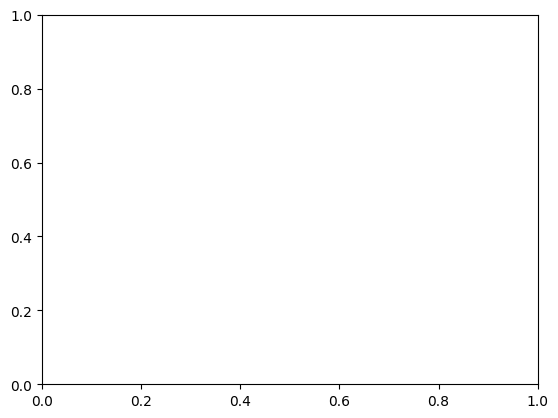

In [ ]:
import matplotlib.pyplot as plt
print(vn)
print(sptm)
plt.figure()
plt.plot(vn,label="vanilla")
plt.plot(sptm,label="sptm")
plt.legend()
plt.show()

##Restart training